## Natural Language Processing (ft. Spotify) 
Carthage Guest Lecture

Benjamin Burch

2024-03-23

Before you start, create a Kaggle account at kaggle.com to download the Spotify data set

Create an API key at https://www.kaggle.com/settings

Place the downloaded kaggle.json file in C:/Users/\<windows user name\>/.kaggle

Set up your Python environment

```
py -m venv ./env
env/Scripts/activate
py -m pip install -U pip wheel setuptools
py -m pip install ipykernel gensim nltk spacy seaborn plotly pandas bertopic kaggle
python -m spacy download en_core_web_lg
```
Download the Spotify Million Song data set https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset/data

``` !kaggle datasets download -d notshrirang/spotify-million-song-dataset```

Make sure to unzip spotify-million-song-dataset.zip into your project folder

# What is Natural Language Processing?

<div>
<img src="./figures/nlp.png" width="800"/>
</div>

# A Brief History of NLP

<div>
<img src="./figures/nlp_history.png" width="800"/>
</div>

In [2]:
# python sys libraries
import re
import itertools
from collections import Counter
from datetime import datetime
import pickle

#standard DS libraries
import numpy as np
import pandas as pd


#nlp libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
#import spacy
from openai import OpenAI #need API key

#plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

#additional setup
from dotenv import load_dotenv
pd.options.display.float_format = '{:,.2f}'.format
load_dotenv()
nltk.download('wordnet')
nltk.download('stopwords')
#spacy.load('en_core_web_lg')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
songs = pd.read_csv('./spotify-million-song-dataset/spotify_millsongdata.csv')

In [4]:
songs.shape

(57650, 4)

In [5]:
songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


<Axes: title={'center': 'Top Artists by Song Count'}, ylabel='artist'>

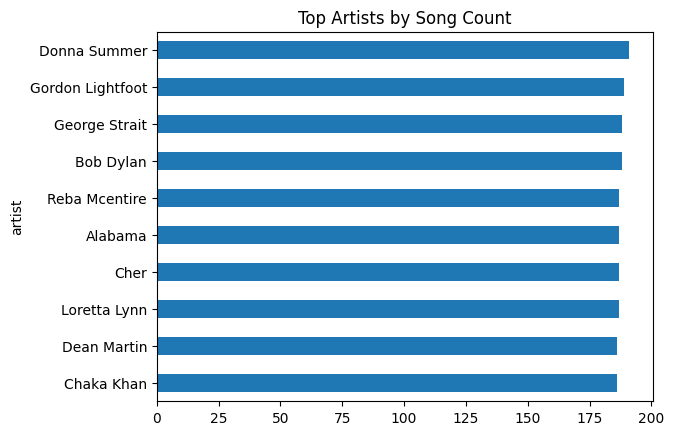

In [6]:
songs.artist.value_counts().head(10).sort_values().plot(kind='barh',title='Top Artists by Song Count' )

In [7]:
print(songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].text.values[0])

We're no strangers to love  
You know the rules and so do I  
A full commitment's what I'm thinking of  
You wouldn't get this from any other guy  
  
I just want to tell you how I'm feeling  
Gotta make you understand  
  
[Chorus:]  
Never gonna give you up, never gonna let you down  
Never gonna run around and desert you  
Never gonna make you cry, never gonna say goodbye  
Never gonna tell a lie and hurt you  
  
We've known each other for so long  
Your heart's been aching but you're too shy to say it  
Inside we both know what's been going on  
We know the game and we're gonna play it  
  
And if you ask me how I'm feeling  
Don't tell me you're too blind to see  
  
[Chorus x2]  
Never gonna give you up, never gonna let you down  
Never gonna run around and desert you  
Never gonna make you cry, never gonna say goodbye  
Never gonna tell a lie and hurt you  
  
(Ooh give you up)  
(Ooh give you up)  
(Ooh) Never gonna give, never gonna give (give you up)  
(Ooh) Never gonna give

In [8]:
songs['tokens']=songs.text.apply(str.split)

In [9]:
all_tokens = list(itertools.chain.from_iterable(songs['tokens']))

In [10]:
print(f"There are {len(all_tokens):,} total tokens!")
print(f"There are {len(set(all_tokens)):,} distinct tokens!")

There are 12,653,383 total tokens!
There are 210,321 distinct tokens!


In [11]:
token_counts = Counter(all_tokens)
token_counts_df = pd.DataFrame.from_dict(token_counts, orient='index',columns=['count']).reset_index().rename(columns={"index":"token"}).sort_values('count', ascending=False)

In [12]:
print(token_counts_df)

              token   count
15              the  446872
49                I  415921
101             you  326267
13               to  273065
5                 a  235203
...             ...     ...
118074  money-maker       1
118070         GTO,       1
118065      turnin4       1
118064      Cranked       1
210320       titans       1

[210321 rows x 2 columns]


Text(0.5, 1.0, 'The top words are really boring')

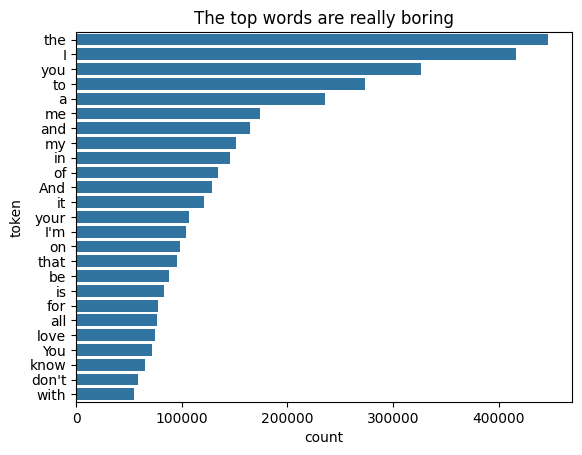

In [13]:
sns.barplot(token_counts_df.head(25), x='count', y='token').set_title('The top words are really boring')

Text(0.5, 1.0, 'The rare words are really weird')

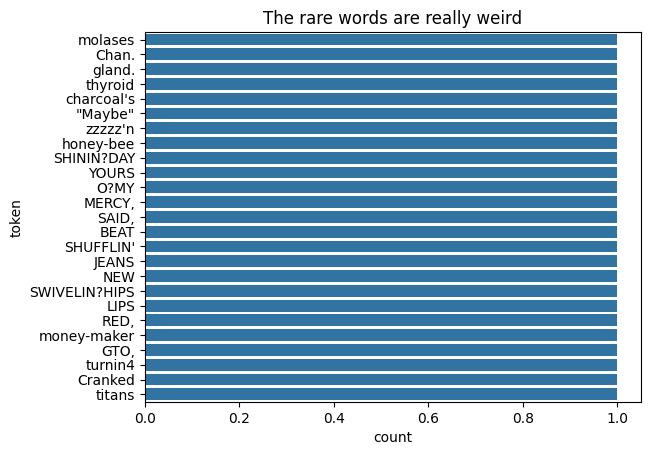

In [14]:
sns.barplot(token_counts_df.tail(25), x='count', y='token').set_title('The rare words are really weird')

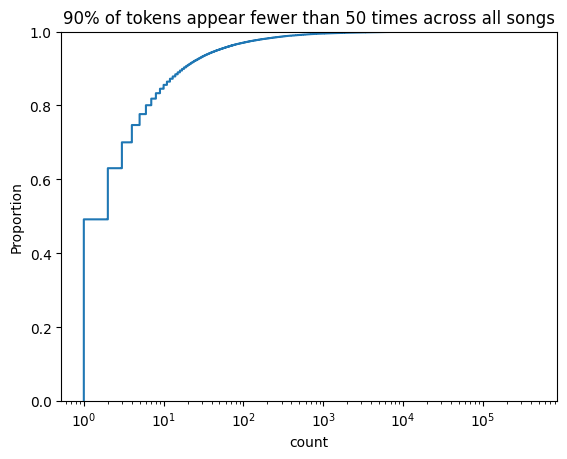

In [15]:
p = sns.ecdfplot(token_counts_df['count'], stat='proportion', log_scale=True).set_title("90% of tokens appear fewer than 50 times across all songs")

### Let's clean this up

1. lowercase everything
2. remove punctuation
3. stemming and lemmatization?
4. remove "stop words"

https://docs.cohere.com/docs/text-pre-processing-in-nlp

https://www.codecademy.com/learn/dsnlp-text-preprocessing/modules/nlp-text-preprocessing/cheatsheet

## 1. Lowercase it all!

In [16]:

songs['text_lower'] = songs['text'].apply(str.lower)
songs[['text','text_lower']].head()

,text,text_lower
0,"Look at her face, it's a wonderful face \r\nA...","look at her face, it's a wonderful face \r\na..."
1,"Take it easy with me, please \r\nTouch me gen...","take it easy with me, please \r\ntouch me gen..."
2,I'll never know why I had to go \r\nWhy I had...,i'll never know why i had to go \r\nwhy i had...
3,Making somebody happy is a question of give an...,making somebody happy is a question of give an...
4,Making somebody happy is a question of give an...,making somebody happy is a question of give an...


## 2. Remove (most) punctuation!

In [17]:
def clean_lyrics(lyrics):
    # Define the pattern to keep apostrophes in contractions and hyphens in compound words
    # Remove other common punctuation
    cleaned_lyrics = re.sub(r"[,\.!?;:()\"\\\/\[\]]", "", lyrics)
    
    # Remove extra whitespace
    cleaned_lyrics = re.sub(r"\s+", " ", cleaned_lyrics).strip()
        
    return cleaned_lyrics

In [18]:
songs['text_lower_rempunct'] = songs['text_lower'].apply(clean_lyrics)
songs[['text','text_lower_rempunct']].head(10)

,text,text_lower_rempunct
0,"Look at her face, it's a wonderful face \r\nA...",look at her face it's a wonderful face and it ...
1,"Take it easy with me, please \r\nTouch me gen...",take it easy with me please touch me gently li...
2,I'll never know why I had to go \r\nWhy I had...,i'll never know why i had to go why i had to p...
3,Making somebody happy is a question of give an...,making somebody happy is a question of give an...
4,Making somebody happy is a question of give an...,making somebody happy is a question of give an...
5,"Well, you hoot and you holler and you make me ...",well you hoot and you holler and you make me m...
6,Down in the street they're all singing and sho...,down in the street they're all singing and sho...
7,"Chiquitita, tell me what's wrong \r\nYou're e...",chiquitita tell me what's wrong you're enchain...
8,I was out with the morning sun \r\nCouldn't s...,i was out with the morning sun couldn't sleep ...
9,I'm waitin' for you baby \r\nI'm sitting all ...,i'm waitin' for you baby i'm sitting all alone...


In [19]:
def plot_top_tokens_from_lyrics(lyrics, topn=20, ax=None, title=None):
    all_tokens = list(itertools.chain.from_iterable(lyrics.apply(str.split)))
    token_counts = Counter(all_tokens)
    token_counts_df = pd.DataFrame.from_dict(token_counts, orient='index',columns=['count']).reset_index().rename(columns={"index":"token"}).sort_values('count', ascending=False)    
    sns.barplot(token_counts_df.head(topn), x='count', y='token',ax=ax).set_title(title)

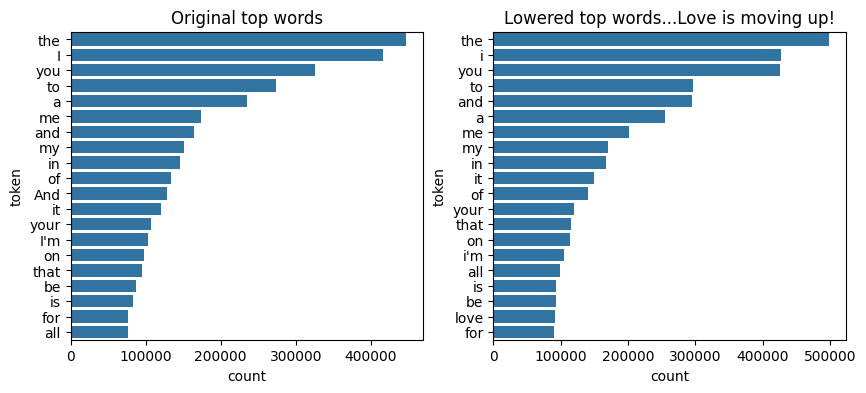

In [20]:
topn=20

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
sns.barplot(token_counts_df.head(topn), x='count', y='token', ax=ax1).set_title('Original top words')
plot_top_tokens_from_lyrics(songs.text_lower_rempunct, topn=topn, ax=ax2, title='Lowered top words...Love is moving up!')


### 3. Stemming vs. lemmatization

<div>
<img src="./figures/stemming_vs_lemmatization.png" width="800"/>
</div>

In [21]:
lemmatizer = WordNetLemmatizer()

def lemmatize(lyric):
    lemmatized_lyric = ' '.join([lemmatizer.lemmatize(token) for token in lyric.split()])
    
    return lemmatized_lyric

songs['text_lower_rempunct_lemma'] = songs['text_lower_rempunct'].apply(lemmatize)
songs[['text','text_lower_rempunct_lemma']].head(10)

,text,text_lower_rempunct_lemma
0,"Look at her face, it's a wonderful face \r\nA...",look at her face it's a wonderful face and it ...
1,"Take it easy with me, please \r\nTouch me gen...",take it easy with me please touch me gently li...
2,I'll never know why I had to go \r\nWhy I had...,i'll never know why i had to go why i had to p...
3,Making somebody happy is a question of give an...,making somebody happy is a question of give an...
4,Making somebody happy is a question of give an...,making somebody happy is a question of give an...
5,"Well, you hoot and you holler and you make me ...",well you hoot and you holler and you make me m...
6,Down in the street they're all singing and sho...,down in the street they're all singing and sho...
7,"Chiquitita, tell me what's wrong \r\nYou're e...",chiquitita tell me what's wrong you're enchain...
8,I was out with the morning sun \r\nCouldn't s...,i wa out with the morning sun couldn't sleep s...
9,I'm waitin' for you baby \r\nI'm sitting all ...,i'm waitin' for you baby i'm sitting all alone...


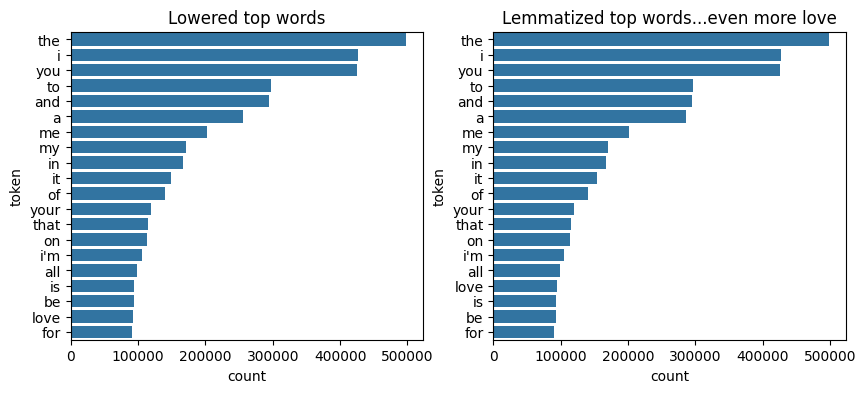

In [22]:
topn=20

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
plot_top_tokens_from_lyrics(songs.text_lower_rempunct, topn=topn, ax=ax1, title='Lowered top words')
plot_top_tokens_from_lyrics(songs.text_lower_rempunct_lemma, topn=topn, ax=ax2, title='Lemmatized top words...even more love')

### 4. Remove Stop Words

Stop word are common word that do not add significant meaning to the text you are working with. 

Your stop words may be different for different use cases!

**THIS IS AN ITERATIVE PROCESS!!!**

<div>
<img src="./figures/stop_words.png" width="300"/>
</div>

In [23]:
stop_words = set(stopwords.words('english')) 
sorted(list(stop_words))[0:25]

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both']

In [24]:
def remove_stopwords(lyric, stop_word_list=stop_words):
    new_lyric = ' '.join([word for word in lyric.split() if word not in stop_word_list])
    return new_lyric

In [25]:
songs['text_lower_rempunct_lemma_nostop'] = songs['text_lower_rempunct_lemma'].apply(remove_stopwords)
songs[['text','text_lower_rempunct_lemma_nostop']].head(10)

,text,text_lower_rempunct_lemma_nostop
0,"Look at her face, it's a wonderful face \r\nA...",look face wonderful face mean something specia...
1,"Take it easy with me, please \r\nTouch me gen...",take easy please touch gently like summer even...
2,I'll never know why I had to go \r\nWhy I had...,i'll never know go put lousy rotten show boy w...
3,Making somebody happy is a question of give an...,making somebody happy question give take learn...
4,Making somebody happy is a question of give an...,making somebody happy question give take learn...
5,"Well, you hoot and you holler and you make me ...",well hoot holler make mad i've always heel hol...
6,Down in the street they're all singing and sho...,street they're singing shouting staying alive ...
7,"Chiquitita, tell me what's wrong \r\nYou're e...",chiquitita tell what's wrong enchained sorrow ...
8,I was out with the morning sun \r\nCouldn't s...,wa morning sun sleep thought i'd take walk wa ...
9,I'm waitin' for you baby \r\nI'm sitting all ...,i'm waitin' baby i'm sitting alone feel cold w...


In [26]:
songs['clean_tokens']=songs.text_lower_rempunct_lemma_nostop.apply(str.split)
clean_tokens = list(itertools.chain.from_iterable(songs['clean_tokens']))

In [27]:
print(f"There are {len(all_tokens):,} total raw tokens!")
print(f"There are {len(set(all_tokens)):,} distinct raw tokens!\n")
print(f"There are {len(clean_tokens):,} total clean tokens!")
print(f"There are {len(set(clean_tokens)):,} distinct clean tokens!")

There are 12,653,383 total raw tokens!
There are 210,321 distinct raw tokens!

There are 6,565,214 total clean tokens!
There are 99,970 distinct clean tokens!


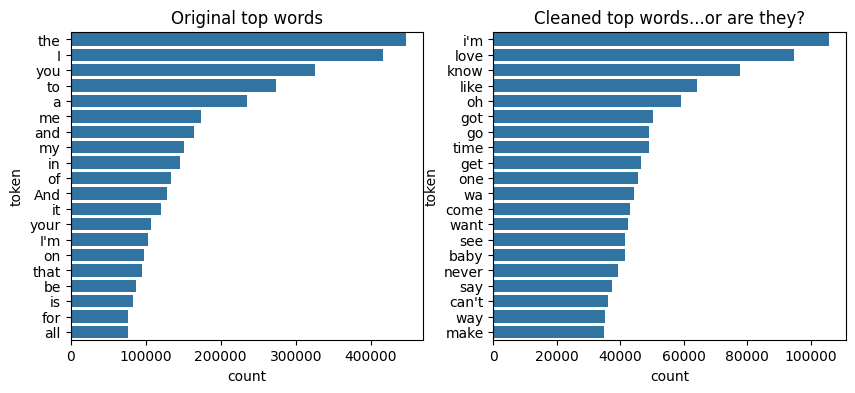

In [28]:
topn=20

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
sns.barplot(token_counts_df.head(topn), x='count', y='token', ax=ax1).set_title('Original top words')
plot_top_tokens_from_lyrics(songs.text_lower_rempunct_lemma_nostop, topn=topn, ax=ax2, title='Cleaned top words...or are they?')

In [29]:
print(f"{songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].text_lower_rempunct_lemma_nostop.values[0][0:112]} ...")
print('\nVS.\n')
print(f"{songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].text.values[0][0:225]}...")

we're stranger love know rule full commitment's i'm thinking get guy want tell i'm feeling gotta make understand ...

VS.

We're no strangers to love  
You know the rules and so do I  
A full commitment's what I'm thinking of  
You wouldn't get this from any other guy  
  
I just want to tell you how I'm feeling  
Gotta make you understand ...


### Let's look at how many words we match.

In [30]:
never_gonna_give_you_tokens_raw = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].tokens.values[0]
never_gonna_give_you_tokens_clean = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')].clean_tokens.values[0]

In [31]:
songs['astley_match_raw'] = songs.tokens.apply(lambda x: set(x) & set(never_gonna_give_you_tokens_raw))
songs['astley_match_clean'] = songs.tokens.apply(lambda x: set(x) & set(never_gonna_give_you_tokens_clean))

In [32]:
songs[['artist', 'song', 'text','astley_match_raw', 'astley_match_clean']].head(10)

,artist,song,text,astley_match_raw,astley_match_clean
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \r\nA...","{And, and, the, we, I, a, to, just, of, me, if...",{}
1,ABBA,"Andante, Andante","Take it easy with me, please \r\nTouch me gen...","{you're, a, know, me, play, I'm, And, and, mak...","{make, let, know, play, feeling}"
2,ABBA,As Good As New,I'll never know why I had to go \r\nWhy I had...,"{a, know, me, I'm, And, and, love, we, make, t...","{never, make, love, know, get}"
3,ABBA,Bang,Making somebody happy is a question of give an...,"{A, you're, around, a, know, Don't, And, and, ...","{love, around, know, give, get, feeling}"
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...,"{A, you're, around, a, know, Don't, And, and, ...","{love, around, know, give, get, feeling}"
5,ABBA,Burning My Bridges,"Well, you hoot and you holler and you make me ...","{And, and, make, the, been, I, no, of, You, a,...","{make, gonna}"
6,ABBA,Cassandra,Down in the street they're all singing and sho...,"{you're, a, know, aching, I'm, And, and, the, ...","{know, aching}"
7,ABBA,Chiquitita,"Chiquitita, tell me what's wrong \r\nYou're e...","{you're, tell, a, know, me, I'm, And, and, the...","{what's, see, cry, tell, know}"
8,ABBA,Crazy World,I was out with the morning sun \r\nCouldn't s...,"{been, tell, blind, a, know, me, what, gonna, ...","{long, never, see, guy, tell, blind, know, thi..."
9,ABBA,Crying Over You,I'm waitin' for you baby \r\nI'm sitting all ...,"{the, we, never, do, to, of, know, me, so, you...","{know, never}"


In [33]:
songs['astley_match_raw_length'] = songs['astley_match_raw'].apply(len)
songs['astley_match_clean_length'] = songs['astley_match_clean'].apply(len)

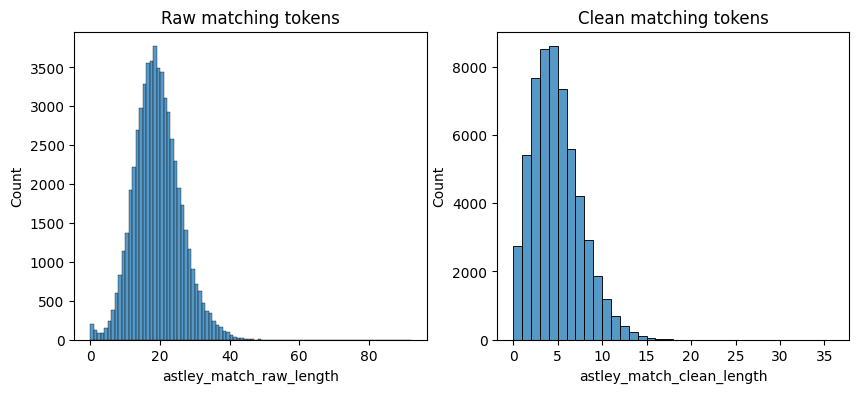

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(10,4))
p=sns.histplot(songs.astley_match_raw_length, binwidth=1, ax=ax1).set_title('Raw matching tokens')
p=sns.histplot(songs.astley_match_clean_length, binwidth=1, ax=ax2).set_title('Clean matching tokens')


In [35]:
top10_raw = songs.sort_values('astley_match_raw_length', ascending=False)[['artist', 'song', 'text','astley_match_raw', 'astley_match_raw_length']].head(10)
top10_raw

,artist,song,text,astley_match_raw,astley_match_raw_length
50844,Rick Astley,Never Gonna Give You Up,We're no strangers to love \r\nYou know the r...,"{you're, around, been, know, goodbye, aching, ...",92
16477,Puff Daddy,Satisfy You,[Puffy] \r\nAll I want is somebody who's gonn...,"{you're, around, understand, game, a, hurt, me...",48
51834,Snoop Dogg,I Believe In You,[Latoiya Williams] \r\nI'm so glad that you b...,"{you're, around, We're, been, we're, a, know, ...",48
43360,Mc Hammer,Crime Story,"Crime stories \r\nYou get, boy, no glory \r\...","{you're, around, been, we're, game, tell, a, k...",47
8862,J Cole,Friday Night,"Yeah, \r\nHey, \r\nYeah, \r\n \r\nPartiall...","{A, around, understand, been, blind, a, know, ...",46
31411,Eminem,Kim,Aw look at daddy's baby girl \r\nThat's daddy...,"{you're, we're, a, me, what, want, I'm, gonna,...",46
5076,Eminem,Farewell,I don't wanna say goodbye \r\nBut sometimes t...,"{A, you're, been, we're, tell, a, know, me, go...",46
30494,Drake,Poetic Justice,"Every second, every minute, man I swear that s...","{A, you're, been, tell, blind, a, know, me, pl...",45
11541,Lil Wayne,Breakin' My Heart,(feat. Little Brother) \r\n \r\nHey baby loo...,"{you're, around, been, game, tell, blind, a, k...",45
41941,LL Cool J,Jack The Ripper,"Milky, and I'm back \r\nMy ace in the hole wa...","{A, you're, around, game, a, know, me, play, w...",45


In [36]:
top10_clean=songs.sort_values('astley_match_clean_length', ascending=False)[['artist', 'song', 'text','astley_match_clean', 'astley_match_clean_length']].head(10)
top10_clean

,artist,song,text,astley_match_clean,astley_match_clean_length
50844,Rick Astley,Never Gonna Give You Up,We're no strangers to love \r\nYou know the r...,"{around, understand, heart's, we're, game, tel...",36
11721,Lionel Richie,Do It To Me,"Girl, you're such a bad thing \r\nStanding th...","{around, heart's, tell, know, hurt, goodbye, w...",20
41941,LL Cool J,Jack The Ripper,"Milky, and I'm back \r\nMy ace in the hole wa...","{around, game, know, play, want, gonna, love, ...",19
15288,Outkast,The Train,All aboard \r\nOr are all y'all bored? \r\nI...,"{long, make, around, never, gotta, let, game, ...",18
16731,R. Kelly,If I'm Wit You,I don't understand \r\nI do all this for you ...,"{long, love, around, understand, gotta, see, g...",17
54667,Usher,Can T Let U Go,"Yo, shit \r\nI'm sick of this man \r\nI can'...","{long, love, around, understand, make, let, sa...",17
57251,YG,Do It To Ya,"Annie, girl, let's play house \r\nAnd you can...","{long, make, around, say, never, let, guy, tel...",17
30664,Dusty Springfield,I'm Gonna Leave You,I've been trying hard to see \r\nJust what yo...,"{love, make, say, never, gotta, cry, see, get,...",17
49206,Puff Daddy,I Hear Voices,Sometimes I don't think you motherfuckers \r\...,"{rule, full, love, around, understand, make, l...",17
16477,Puff Daddy,Satisfy You,[Puffy] \r\nAll I want is somebody who's gonn...,"{long, love, around, understand, make, let, ga...",17


In [37]:
pd.concat([top10_raw[['artist', 'song']].reset_index(drop=True), top10_clean[['artist', 'song']].reset_index(drop=True)], axis=1)

,artist,song,artist,song
0,Rick Astley,Never Gonna Give You Up,Rick Astley,Never Gonna Give You Up
1,Puff Daddy,Satisfy You,Lionel Richie,Do It To Me
2,Snoop Dogg,I Believe In You,LL Cool J,Jack The Ripper
3,Mc Hammer,Crime Story,Outkast,The Train
4,J Cole,Friday Night,R. Kelly,If I'm Wit You
5,Eminem,Kim,Usher,Can T Let U Go
6,Eminem,Farewell,YG,Do It To Ya
7,Drake,Poetic Justice,Dusty Springfield,I'm Gonna Leave You
8,Lil Wayne,Breakin' My Heart,Puff Daddy,I Hear Voices
9,LL Cool J,Jack The Ripper,Puff Daddy,Satisfy You


## Can we do better?

1. There were still a lot of noise words in there.
2. There could be misspellings (mispellings? ms. pellings?).
3. Lots of word are spelled differently but have similar meaning
4. Context matters!



<div>
<img src="./figures/classic_v_deep.png" width="800"/>
</div>

### ENTER WORD VECTORS TO SAVE THE DAY!

<div>
<img src="./figures/super_word_vector.png" width="400"/>
</div>

### One-hot encoding

1. The CURSE OF DIMENSIONALITY!!!!
2. So sparse!
3. Synonyms, antonyms
4. But where is the context?
5. Still doesn't fix the frequent word problem

<div>
<img src="./figures/word_bird.png" width="600"/>
</div>

### word2vec

<div>
<img src="./figures/word2vec.png" width="800"/>
</div>

<div>
<img src="./figures/w2v.jpg" width="800"/>
</div>

<div>
<img src="./figures/vector_relationships.png" width="800"/>
</div>

<div>
<img src="./figures/word_distribution.png" width="800"/>
</div>

<div>
<img src="./figures/newsgroup.png" width="500"/>
</div>

## State of the Art

In [38]:
client = OpenAI()

In [39]:
def get_open_ai_embedding(lyrics):
    response = client.embeddings.create(input=lyrics,model="text-embedding-3-small")
    return response

In [60]:
# 20 min and $0.40 later....
batch_size = 1500  # Set your batch size
embeddings = []

for i in range(0, len(songs.text), batch_size):
    print(f"Running batch {i}: ", datetime.now())
    batch = list(songs.text)[i:i + batch_size]
    result = get_open_ai_embedding(batch)
    embeddings.append(result.data)

Running batch 0:  2024-03-24 19:10:30.878302


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
vectors = list(itertools.chain.from_iterable(embeddings))
print(len(vectors))

In [ ]:
songs['openai_embeddings'] = vectors
songs['openai_embeddings'] =songs['openai_embeddings'].apply(lambda x:np.array(x.embedding))

In [ ]:
songs.to_pickle('songs.pkl')

In [ ]:
astley_vector = songs[(songs.artist=='Rick Astley') & (songs.song=='Never Gonna Give You Up')]['openai_embeddings'].values[0]
print(astley_vector)

[ 0.00545065 -0.00360638 -0.01963821 ...  0.01459551  0.01798376
  0.00827797]


In [ ]:
all_vectors = np.stack(songs['openai_embeddings'].values)

In [ ]:
def normalize_vector(v):
    """Normalize a vector to unit length."""
    norm = np.linalg.norm(v)
    return v if norm == 0 else v / norm

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two vectors."""
    # Ensure both vectors are normalized
    v1_normalized = normalize_vector(v1)
    v2_normalized = normalize_vector(v2)
    
    # Calculate cosine similarity and convert to cosine distance
    cosine_similarity = np.dot(v1_normalized, v2_normalized)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [ ]:
# Calculate cosine distance between the reference vector and each of the other vectors
distances = [cosine_distance(astley_vector, vec) for vec in all_vectors]
songs['openai_embedding_distances'] = distances 
songs.sort_values('openai_embedding_distances')[['artist', 'song']].head(10)


,artist,song
50844,Rick Astley,Never Gonna Give You Up
17829,Rod Stewart,Heart Is On The Line
50852,Rick Astley,Take Me To Your Heart
42552,Madonna,Never Let You Go
33140,Freestyle,Coro - Can't Let You Go
41818,Lionel Richie,I Call It Love
24461,Backstreet Boys,End Of The Road
39666,Kelly Clarkson,Don't Let Me Stop You
19403,Tom Jones,Never
24488,Backstreet Boys,I'll Be There For You


In [ ]:
top10_openai = songs.sort_values('openai_embedding_distances')[['artist', 'song','openai_embedding_distances']].head(10)
top10_openai

,artist,song,openai_embedding_distances
50844,Rick Astley,Never Gonna Give You Up,-0.00
17829,Rod Stewart,Heart Is On The Line,0.23
50852,Rick Astley,Take Me To Your Heart,0.24
42552,Madonna,Never Let You Go,0.24
33140,Freestyle,Coro - Can't Let You Go,0.24
41818,Lionel Richie,I Call It Love,0.24
24461,Backstreet Boys,End Of The Road,0.24
39666,Kelly Clarkson,Don't Let Me Stop You,0.24
19403,Tom Jones,Never,0.25
24488,Backstreet Boys,I'll Be There For You,0.25


In [ ]:
pd.concat([top10_raw[['artist', 'song']].reset_index(drop=True), top10_clean[['artist', 'song']].reset_index(drop=True), top10_openai[['artist', 'song']].reset_index(drop=True)], axis=1)

,artist,song,artist,song,artist,song
0,Rick Astley,Never Gonna Give You Up,Rick Astley,Never Gonna Give You Up,Rick Astley,Never Gonna Give You Up
1,Puff Daddy,Satisfy You,Lionel Richie,Do It To Me,Rod Stewart,Heart Is On The Line
2,Snoop Dogg,I Believe In You,LL Cool J,Jack The Ripper,Rick Astley,Take Me To Your Heart
3,Mc Hammer,Crime Story,Outkast,The Train,Madonna,Never Let You Go
4,J Cole,Friday Night,R. Kelly,If I'm Wit You,Freestyle,Coro - Can't Let You Go
5,Eminem,Kim,Usher,Can T Let U Go,Lionel Richie,I Call It Love
6,Eminem,Farewell,YG,Do It To Ya,Backstreet Boys,End Of The Road
7,Drake,Poetic Justice,Dusty Springfield,I'm Gonna Leave You,Kelly Clarkson,Don't Let Me Stop You
8,Lil Wayne,Breakin' My Heart,Puff Daddy,I Hear Voices,Tom Jones,Never
9,LL Cool J,Jack The Ripper,Puff Daddy,Satisfy You,Backstreet Boys,I'll Be There For You


In [ ]:
print(songs[(songs.artist=='Rod Stewart') & (songs.song=='Heart Is On The Line')].text.values[0])

What do you want from me  
When will you ever see  
I gave it all nothing less  
The feeling ain't mutual I guess  
Why am I so confused  
Why do I feel so used  
This game at hand was made for two  
But somehow I played without you  
  
No I'm not sad  
Nothin' lasts forever  
Head over heels  
Better late than never  
  
[Chorus]  
My heart is on the line  
Running out of time  
Love stop making a fool out of me  
My heart is on the line  
Running out of time  
Love stop making a fool out of me  
  
Telling my friends you're fine  
Even our favorite wine  
But you're not there and it hurts  
Nobody knows how it hurts  
Maybe I thought I knew  
That I belonged to you  
I dreamed a dream I couldn't have  
I foolishly let myself dance  
Inside your eyes  
Oh don't be sad  
I should've known better  
Why didn't I realize  
  
[Chorus]  
  
Love stop making a fool out of me  
Love stop making a fool out of me  
  
Whenever you call me up  
Everything else must stop  
My heart says stay bu

In [ ]:
def find_closest_songs(artist, song, topn=10, most_similar=True):
    song_vector = songs[(songs.artist==artist) & (songs.song==song)]['openai_embeddings'].values[0]
    distances = [cosine_distance(song_vector, vec) for vec in all_vectors]
    songs[f'openai_embedding_distances_{artist}_{song}'] = distances
    top_songs = songs.sort_values(f'openai_embedding_distances_{artist}_{song}', ascending=most_similar)[['artist', 'song',f'openai_embedding_distances_{artist}_{song}']].head(topn)
    return top_songs

In [ ]:
find_closest_songs('Queen', 'Bohemian Rhapsody')

,artist,song,openai_embedding_distances_Queen_Bohemian Rhapsody
49284,Queen,Bohemian Rhapsody,-0.00
55888,Weird Al Yankovic,Bohemian Polka,0.01
29267,Deep Purple,Slow Train,0.25
55965,Westlife,Bop Bop Baby,0.26
35788,Helloween,When The Sinner,0.26
474,Alice Cooper,Ballad Of Dwight Fry,0.27
21342,Wham!,The Edge Of Heaven,0.27
8607,INXS,Hungry,0.27
33760,George Michael,Edge Of Heaven,0.27
14714,Offspring,I Choose,0.27


In [ ]:
find_closest_songs('Bob Dylan', 'House Of The Rising Sun')

,artist,song,openai_embedding_distances_Bob Dylan_House Of The Rising Sun
25848,Bob Dylan,House Of The Rising Sun,-0.00
30334,Doors,House Of The Rising Sun,0.05
53846,Tracy Chapman,House Of The Rising Sun,0.07
55713,Waylon Jennings,House Of The Rising Sun,0.07
14147,Nina Simone,House Of The Rising Sun,0.07
19595,Toto,House Of The Rising Sun,0.09
28219,Conway Twitty,House Of The Rising Sun,0.11
12411,Marianne Faithfull,House Of The Rising Sun,0.14
10522,Kid Rock,New Orleans,0.23
19884,U2,The Saints Are Coming,0.24


In [ ]:
find_closest_songs('Whitney Houston', 'I Will Always Love You')

,artist,song,openai_embedding_distances_Whitney Houston_I Will Always Love You
56263,Whitney Houston,I Will Always Love You,-0.00
34082,Glee,I Will Always Love You,0.01
41721,Linda Ronstadt,I Will Always Love You,0.03
20809,Vince Gill,I Will Always Love You,0.03
40068,Kenny Rogers,I Will Always Love You,0.04
11288,Leann Rimes,I Will Always Love You,0.07
312,Air Supply,My Hearts With You,0.25
26858,Carol Banawa,Stay,0.25
30654,Dusty Springfield,I Will Always Want You,0.25
40265,Kim Wilde,Now And Forever,0.25


In [ ]:
find_closest_songs('Rick Astley', 'Never Gonna Give You Up', most_similar=False)

,artist,song,openai_embedding_distances_Rick Astley_Never Gonna Give You Up
32972,Frank Zappa,"Food Gathering In Post-industrial America, 1992",0.90
8841,Iwan Fals,Coretan Dinding,0.90
37298,Iwan Fals,Hura-hura Huru-hara,0.88
15159,Our Lady Peace,R.K. 1949-97,0.87
8844,Iwan Fals,Sore Tugu Pancoran,0.84
54860,Vangelis,Albedo 0. 39,0.83
44357,The Monkees,Peter Percival Pattersons Pet Pig Porky,0.83
3804,David Bowie,Leon Takes Us Outside,0.83
57111,Yello,Beyond Mirrors,0.83
46182,NOFX,Canada Has Better Heroin,0.83


In [ ]:
find_closest_songs('Whitney Houston', 'I Will Always Love You', most_similar=False)

,artist,song,openai_embedding_distances_Whitney Houston_I Will Always Love You
15159,Our Lady Peace,R.K. 1949-97,0.93
32972,Frank Zappa,"Food Gathering In Post-industrial America, 1992",0.89
8841,Iwan Fals,Coretan Dinding,0.89
37298,Iwan Fals,Hura-hura Huru-hara,0.87
12737,Megadeth,Psychotron,0.86
54860,Vangelis,Albedo 0. 39,0.86
46182,NOFX,Canada Has Better Heroin,0.86
44357,The Monkees,Peter Percival Pattersons Pet Pig Porky,0.85
57111,Yello,Beyond Mirrors,0.85
46225,NOFX,Punk Guy,0.85


In [ ]:
find_closest_songs('Queen', 'Bohemian Rhapsody', most_similar=False)

,artist,song,openai_embedding_distances_Queen_Bohemian Rhapsody
8841,Iwan Fals,Coretan Dinding,0.86
3804,David Bowie,Leon Takes Us Outside,0.85
15159,Our Lady Peace,R.K. 1949-97,0.83
32972,Frank Zappa,"Food Gathering In Post-industrial America, 1992",0.79
46182,NOFX,Canada Has Better Heroin,0.78
44357,The Monkees,Peter Percival Pattersons Pet Pig Porky,0.77
54860,Vangelis,Albedo 0. 39,0.76
37298,Iwan Fals,Hura-hura Huru-hara,0.75
55937,Weird Al Yankovic,Polkamon,0.75
40723,Koes Plus,Bunga Rindu,0.75


In [ ]:
print(songs[(songs.artist=='Frank Zappa')&(songs.song=='Food Gathering In Post-industrial America, 1992')].text.values[0])

"Food Gathering In Post-Industrial America, 1992."  
  
When the last decrepit factory has dumped its final load of toxic waste into
the water supply and shipped its last badly manufactured, incompetently
designed consumer thing, we gaze in astonishment as the denizens of NU-PERFECT
AMERICA, dine on rats (mmmmm), poodles, Styrofoam packing pellets, all
floating in a broth of tritium-enriched sewage, roasting the least diseased
body parts of abandoned wild children accumulating since the total ban on
abortion a few years back.




In [ ]:
print(songs[(songs.artist=='Our Lady Peace')&(songs.song=='R.K. 1949-97')].text.values[0])

In 1949 George Orwell portrays a chilling world in which computers are used by  
Large bureaucracies to monitor and enslave the population in his book 1984.  
The year is 1976.  
Kurzweil Computer Products introduces the Kurzweil Reading Machine.  
The first printed speech reading machine for the blind.  
In 1997, Deep Blue beats  
Gary Kasparov, the world chess champion, in a regulation tournament.




In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(min_df=5, ngram_range=(1, 2))

In [ ]:
from bertopic.representation import KeyBERTInspired

keybert_model = KeyBERTInspired()

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=keybert_model,

  # Hyperparameters
  top_n_words=15,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(songs.text.values, np.stack(songs['openai_embeddings'].values))

# Show topics
topic_model.get_topic_info()

2024-03-24 18:26:29,262 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
c:\Users\benja\Code\carthage-lecture\env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-03-24 18:27:26,702 - BERTopic - Dimensionality - Completed ✓
2024-03-24 18:27:26,704 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 18:27:31,207 - BERTopic - Cluster - Completed ✓
2024-03-24 18:27:31,213 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
topic_model.save("./", serialization="safetensors", save_ctfidf=True)